###### %%writefile test
## Practice (Morphological Filter)
1. Input image from gear_tooth.png.
2. The objective is to detect missing teeth using a sequence of morphological filters.
3. Optional: Design a set of structure elements: <b>gear_body</b>, <b>sampling_ring_spacer</b>, <b>sampling_ring_width</b>, <b>tip_spacing</b>, <b>defect_cue</b>
4. Apply morphological filters using the structure elements to generate the figures (e), (f), (g), (h)
<br>&nbsp;(e) opening it with structure element <b>gear_body</b> to get rid of the teeth, dilating that with structure element <b>sampling_ring_spacer</b> to bring it out to the base of the teeth, dilating that with the structure element <b>sampling_ring_width</b> to bring the next image out to the tip of the teeth, and subtracting the last two results to get a ring that just fits over the teeth.
<br>&nbsp;(f) AND it with the original image to produce an image of just the teeth.
<br>&nbsp;(g) (optional) dilating the teeth image with the structure element <b>tip_spacing</b> produces the solid ring image which has spaces in the solid ring wherever there are defects in the teeth.
<br>&nbsp;(h) (optional) subtracting it from the sampling ring leaves only the defects, which are dilated by structure element <b>defect_cue</b>.
5. (optional) Mark the defected gears using <b>red rectangles</b> on the output images.
6. Write a simple report in a separate cell.
7. Upload your Jupyter code file (*.ipynb)
![gear_tooth_procedure.png](attachment:gear_tooth_procedure.png)

In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

In [2]:
img = cv2.imread('gear_tooth.png')


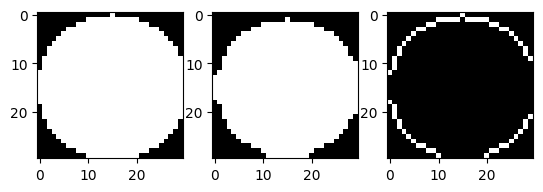

In [3]:
retval, img_A = cv2.threshold(img, 225, 255, cv2.THRESH_BINARY)

kernel_dot = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(3,3))
kernel_hole = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(30,30))
kernel_hole_e = cv2.erode(kernel_hole, kernel_dot, iterations=1)
kernel_hole_ring = kernel_hole - kernel_hole_e
plt.subplot(1,3,1)
plt.imshow(kernel_hole, cmap = 'gray')
plt.subplot(1,3,2)
plt.imshow(kernel_hole_e, cmap = 'gray')
plt.subplot(1,3,3)
plt.imshow(kernel_hole_ring, cmap = 'gray')

img_B = cv2.erode(img_A, kernel_hole_ring, iterations=1)
img_C = cv2.dilate(img_B, kernel_hole, iterations=1)
img_D = cv2.bitwise_or(img, img_C)

cv2.imshow('(a)', img_A)
cv2.imshow('(b)', img_B)
cv2.imshow('(c)', img_C)
cv2.imshow('(d)', img_D)

cv2.waitKey()
cv2.destroyAllWindows()


In [5]:
scale = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(5,5))

img_dilate = cv2.dilate(img_D, scale, iterations=1)
img_dilate2 = cv2.dilate(img_dilate, scale, iterations=1)
img_dilate3 = cv2.dilate(img_dilate2, scale, iterations=1)
gear_images = img_dilate2 - img_D
gear_images = cv2.morphologyEx(gear_images, cv2.MORPH_CLOSE, scale)
Result = cv2.bitwise_and(gear_images, img_D)

cv2.imshow('Input', img_D)
cv2.imshow('B1', img_dilate)
cv2.imshow('B2', gear_images)
cv2.imshow('B3', Result)

cv2.waitKey()
cv2.destroyAllWindows()

In [39]:
kernel = cv2.getStructuringElement(cv2.MORPH_RECT,(20,20))
img_dilate = cv2.dilate(img_D, kernel, iterations=1)
img_erode = cv2.erode(img_dilate, kernel, iterations=1)
img_open = cv2.morphologyEx(img_D, cv2.MORPH_OPEN, kernel)
img_close = cv2.morphologyEx(img_D, cv2.MORPH_CLOSE, kernel)
img_gradient = cv2.morphologyEx(img_D, cv2.MORPH_GRADIENT, kernel)
img_tophat = cv2.morphologyEx(img_D, cv2.MORPH_TOPHAT, kernel)
img_blackhat = cv2.morphologyEx(img_D, cv2.MORPH_BLACKHAT, kernel)

cv2.imshow('B7', img_blackhat)
cv2.waitKey(0)
cv2.destroyAllWindows()

## Result

According to the result, We can find that use the method getStructuringElement in OpenCV, manipulate images according to their shapes. A structuring element is added by morphological processes to an input image to produce an output image of the same size. When performing a morphological operation, each output pixel’s value is determined by comparing it to its neighbors in the input image.

## Reference

1. https://docs.opencv.org/4.x/dd/dd7/tutorial_morph_lines_detection.html

2. https://blog.csdn.net/weixin_42512684/article/details/111087122

3. https://stackoverflow.com/questions/67117928/how-to-decide-on-the-kernel-to-use-for-dilations-opencv-python